In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import time
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

data_path = "../data/histograms/"

In [2]:
#variables
VAL_PCT = 0.2
N_EVENTS = 10000
EPOCHS = 100
CUDA = torch.device('cuda') 
MODEL_NAME = "jet_nr_resnet-" + str(int(time.time()))
RESOLUTION = int(80)
print(MODEL_NAME)

jet_nr_resnet-1643806376


In [3]:
def load_pickle_file(path, file_name):
    return pickle.load(open(path + file_name, 'rb') )



class CalorimeterDataset(Dataset):
    def __init__(self, images, labels):
            self.img_labels = labels
            self.images = images
            
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.img_labels[idx]
        return image, label

def label_maker(labels, max_value):
    label_lists = torch.zeros([len(labels), max_value + 1])
    labels[labels > max_value] = max_value
    for i in range (0, len(labels)):
        label = labels[i]
        label_lists[i, label] = 1 
    return label_lists

def normalize(AA, batchsize):
    print(AA.size())
    AA = AA.view(AA.size(0), -1)
    AA -= AA.min(1, keepdim=True)[0]
    AA /= AA.max(1, keepdim=True)[0]
    AA = AA.view(batchsize, 80, 80, 1)
    print(AA.size())
    return AA

def load_data(input_file, label_file):
    val_size = int(N_EVENTS*VAL_PCT)
    train_size = int(N_EVENTS*(1-VAL_PCT))
    
    Cal_train = torch.tensor(load_pickle_file(data_path, input_file)[:-val_size]).unsqueeze(3).float().cuda()
    Cal_train = normalize(Cal_train, len(Cal_train))
    labels_train = torch.tensor(load_pickle_file(data_path, label_file)[:-val_size]).cuda()
    labels_train = label_maker(labels_train, 2)

    Cal_test = torch.tensor(load_pickle_file(data_path, input_file)[-val_size:]).unsqueeze(3).float().cuda()
    Cal_test = normalize(Cal_test, len(Cal_test))
    labels_test = torch.tensor(load_pickle_file(data_path, label_file)[-val_size:]).cuda()
    labels_test = label_maker(labels_test, 2)
    
    train_dataset = CalorimeterDataset(Cal_train, labels_train)
    test_dataset = CalorimeterDataset(Cal_test, labels_test)
    
    return train_dataset, test_dataset


class Block(nn.Module):
    def __init__(self, num_layers, in_channels, out_channels, identity_downsample=None, stride=1):
        assert num_layers in [18, 34, 50, 101, 152], "should be a a valid architecture"
        super(Block, self).__init__()
        self.num_layers = num_layers
        if self.num_layers > 34:
            self.expansion = 4
        else:
            self.expansion = 1
        # ResNet50, 101, and 152 include additional layer of 1x1 kernels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        if self.num_layers > 34:
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        else:
            # for ResNet18 and 34, connect input directly to (3x3) kernel (skip first (1x1))
            self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        if self.num_layers > 34:
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, num_layers, block, image_channels, num_classes):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Unknown architecture! Number of layers has ' \
                                                     f'to be 18, 34, 50, 101, or 152 '
        super(ResNet, self).__init__()
        if num_layers < 50:
            self.expansion = 1
        else:
            self.expansion = 4
        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34 or num_layers == 50:
            layers = [3, 4, 6, 3]
        elif num_layers == 101:
            layers = [3, 4, 23, 3]
        else:
            layers = [3, 8, 36, 3]
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(num_layers, block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(num_layers, block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(num_layers, block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(num_layers, block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.expansion, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(intermediate_channels*self.expansion))
        layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        return nn.Sequential(*layers)


def ResNet18(img_channels=3, num_classes=1000):
    return ResNet(18, Block, img_channels, num_classes)


def ResNet34(img_channels=3, num_classes=1000):
    return ResNet(34, Block, img_channels, num_classes)


def ResNet50(img_channels=3, num_classes=1000):
    return ResNet(50, Block, img_channels, num_classes)


def ResNet101(img_channels=3, num_classes=1000):
    return ResNet(101, Block, img_channels, num_classes)


def ResNet152(img_channels=3, num_classes=1000):
    return ResNet(152, Block, img_channels, num_classes)


def fwd_pass(net, X, y, train=False):
    if train:
        net.zero_grad()
    outputs = net(X.view(-1, 1, 80, 80).cuda())
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)
    loss = F.cross_entropy(outputs, y.cuda()) # loss_function(outputs, y)
    
    if train:
        loss.backward()
        optimizer.step()
    return acc, loss

def test(net, data, size = 32):
    dataset = DataLoader(data, size, shuffle=True) #shuffle data and choose batch size
    X, y = next(iter(dataset)) #get a random batch
    val_acc, val_loss = fwd_pass(net, X, y)
    return val_acc, val_loss
    
def predict(net, data):
    dataset = DataLoader(data, 1, shuffle=True) #shuffle data and choose batch size
    prediction = torch.zeros(len(dataset))
    truth = torch.zeros(len(dataset))
    i = 0
    for data in tqdm(dataset):
        X, y = data
        output = net(X.view(-1, 1, 80, 80).cuda())
        prediction[i] = torch.argmax(output)
        truth[i] = torch.argmax(y)
        i = i +1
    return truth, prediction
        

def train(net, traindata, testdata, size, epochs):
    dataset = DataLoader(traindata, size, shuffle=True)
    df_labels = ["Loss", "Accuracy", "Validation loss", "Validation accuracy", "Epoch", "Iteration"]
    df_data = [[0], [0], [0], [0], [0], [0]]
    df = pd.DataFrame(dict(zip(df_labels, df_data)))
    i = 0
    for epoch in tqdm(range(epochs)):
        for data in dataset:
            i = i+1
            X, y = data
            acc, loss = fwd_pass(net, X, y, train=True)
            if i % 10 == 0:
                val_acc, val_loss = test(net, testdata, size=size)
                df_data = [float(loss), acc, float(val_loss), val_acc, epoch, i]
                #print(df_labels, df_data)
                new_df = pd.DataFrame(dict(zip(df_labels, df_data)), index=[0])
                df = pd.concat([df, new_df], ignore_index=True)
    return df

In [4]:
#load data
traindata, testdata = load_data('jets_part1_10000events_80x80_min1jet.pkl', 'jets_part1_10000events_80x80_min1jet_labels_njets.pkl')

/tmp/ipykernel_37665/1947042941.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  Cal_train = torch.tensor(load_pickle_file(data_path, input_file)[:-val_size]).unsqueeze(3).float().cuda()


torch.Size([8000, 80, 80, 1])
torch.Size([8000, 80, 80, 1])
torch.Size([2000, 80, 80, 1])
torch.Size([2000, 80, 80, 1])


In [15]:
import numpy as np
x = np.random.randint(1, high = 100)
k = [1+x, 100+x, 1000+x, 8001+x, 8100+x, 9000+x]
n_jets = [0,0,0,2,2,2]
images = [traindata.images[item].cpu() for item in k]
labels = [traindata.img_labels[item].cpu() for item in k]


def cal_image_plot(ax, n_jets):
    ax.set_ylabel(r"$\phi$ [radians]]", fontsize=16)
    ax.set_xlabel(r"$\eta$", fontsize=16)
    ax.set_title(str(n_jets), fontsize=20, color="black")
    ax.tick_params(which="both", direction="inout", top=True, right=True, labelsize=14, pad=15, length=4, width=2)
    ax.tick_params(which="major", length=8)
    ax.tick_params(which="major", length=6)
    ax.minorticks_on()

fig, axs = plt.subplots(nrows = 1, ncols = 6, figsize = (24,4))
for i in range (len(k)):
    cal_image_plot(axs[i], n_jets[i])
    axs[i].imshow(images[i], extent=[-2.5, 2.5, -np.pi, np.pi], aspect='auto')

IndexError: index 8044 is out of bounds for dimension 0 with size 8000

tensor([0., 0., 1.])


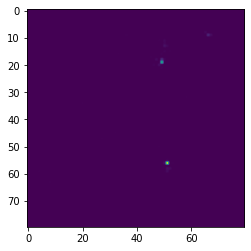

In [5]:
test_image, test_label = traindata[0]
print(test_label)
test_image = test_image.cpu()
plt.imshow(test_image)

In [6]:
def tester():
    RESOLUTION = 256
    net = ResNet18(img_channels=1, num_classes=5)
    #net.to(device = CUDA)
    #y = net(torch.randn(4, 1, 80, 80))
    y = net(test_image.view(-1, 1, 80, 80))
    truth = test_label
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(y, truth)]
    pred = torch.argmax(y)
    print(y.size())
    print(y)
    print("Prediction: ", pred)

tester()

torch.Size([1, 5])
tensor([[-0.2461, -0.2188,  0.1731,  0.5450, -0.8747]],
       grad_fn=<AddmmBackward0>)
Prediction:  tensor(3)


In [7]:
#create NN
net = ResNet18(img_channels=1, num_classes=3)
net.to(device = CUDA)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [8]:
training_results = train(net, traindata, testdata, 100, 100)

100%|██████████| 100/100 [03:46<00:00,  2.27s/it]


In [9]:
truth, preds = predict(net, testdata)

100%|██████████| 2000/2000 [00:09<00:00, 216.24it/s]


In [10]:
print(preds[:50])
print(truth[:50])

tensor([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])
tensor([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 0.,
        2., 2., 0., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 0., 0., 2., 2., 2.,
        2., 2., 0., 2., 0., 2., 2., 2., 2., 2., 0., 2., 2., 2.])


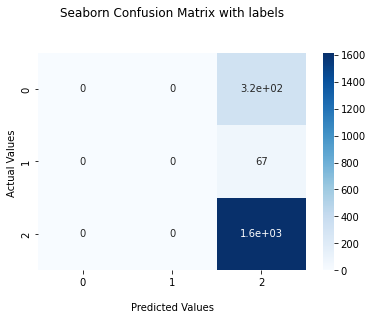

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

#Generate the confusion matrix
cf_matrix = confusion_matrix(truth, preds)
ax = sn.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1', '2'])
ax.yaxis.set_ticklabels(['0','1', '2'])

## Display the visualization of the Confusion Matrix.
plt.show()

<AxesSubplot:xlabel='Iteration'>

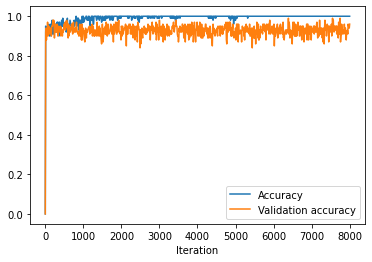

In [12]:
training_results.plot("Iteration", ["Accuracy", "Validation accuracy"])

<AxesSubplot:xlabel='Iteration'>

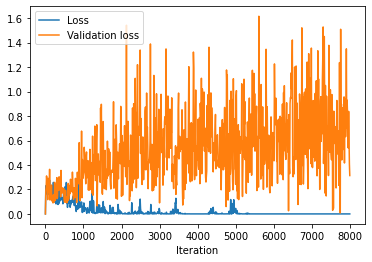

In [13]:
training_results.plot("Iteration", ["Loss", "Validation loss"])

In [14]:
training_results

,Loss,Accuracy,Validation loss,Validation accuracy,Epoch,Iteration
0,0.000000e+00,0.00,0.000000,0.00,0,0
1,2.179687e-01,0.95,0.189174,0.92,0,10
2,2.322035e-01,0.90,0.220509,0.94,0,20
3,1.659935e-01,0.94,0.310513,0.88,0,30
4,2.175272e-01,0.92,0.263945,0.93,0,40
...,...,...,...,...,...,...
796,1.403070e-06,1.00,0.538696,0.96,99,7960
797,1.418535e-06,1.00,0.838108,0.95,99,7970
798,6.855547e-06,1.00,0.587836,0.95,99,7980
799,7.271681e-07,1.00,0.408320,0.94,99,7990
